In [1]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score


#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts

#TS Fresh Parameter Settings
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.feature_extraction import extract_features

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))


#### Param Grids

In [4]:
RF_param_grid = { 
    'n_estimators': [1,2,3, 10, 40,100,250],
    'max_features': [None, 'sqrt'],
    'max_depth' : [2,3,5,8, None],
    'criterion' :['gini',  'entropy'],
    'min_samples_split' : [2,3,4,5]}

DT_params =  {
    'min_samples_leaf': [1, 2, 3 , 5 ,10],
    'max_depth': [1, 2, 3, 5, None],
    'criterion': ["gini", "entropy"],
    'max_features': [None, 'sqrt']}

Ada_grid =  { 
    'n_estimators': [2, 3, 5, 10, 20, 40, 50, 100],
    'learning_rate': [0.01,0.05,  0.1, 0.2, 0.4, 1.0 , 2.0, 10.0]
    }


SVC_grid = {'C': [0.1, 1, 10, 100, 1000], 
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['linear', 'rbf']} 

#### Construct list of settings for experiments

In [6]:
data_type = 'N1'
TS_Fresh_setting, connectivity_setting = 'Minimal' , 'beta'

settings = [] 

for data_type in  ['REM', 'N1', 'N2', 'N3', 'Wake']:
    for expt_num in [1,2]:
        for num_splits in [4]:
            #Define Classifiers , they must be defined after num_splits but before clf_dicts
            DT_dict = {'DT' : GridSearchCV( DecisionTreeClassifier(), DT_params , refit = True, verbose = 1, cv = GroupKFold(n_splits = num_splits) ) }
            # RF_dict = {'RF' : GridSearchCV( RandomForestClassifier(n_jobs = -1), RF_param_grid , refit = True, verbose = 1, cv = GroupKFold(n_splits = num_splits)  ) }
            Ada_dict = {'Ada' : GridSearchCV( AdaBoostClassifier(), Ada_grid , refit = True, verbose = 1, cv = GroupKFold(n_splits = num_splits) ) }
            Svc_dict = {'SVC' : GridSearchCV( SVC(), SVC_grid , refit = True, verbose = 1, cv = GroupKFold(n_splits = num_splits) ) }
            
            for clf_dict in [DT_dict , Ada_dict , Svc_dict]:
                settings.append( (data_type, expt_num , num_splits , clf_dict))

# data_type, expt_num , num_splits , clf_dict = settings[int(sys.argv[1])]

#### Moving up a level in directory chain

In [14]:
os.pardir

'..'

In [16]:
# Navigate up one level
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))


#### Load and save the single region only (no connectivity) models

In [3]:
t1 = time.time()

folder = '../tuned_region_only_models_and_results/run_2'
data_types = ['N1','REM', 'N2', 'N3', 'Wake']
expt_nums = [1,2]
models = ['DT', 'Ada']
TS_Fresh_settings = ['Minimal', 'Efficient']
num_splits = 4

clfs_dicts_loaded = {}
results_dfs_loaded = {}

for data_type in data_types: 
    for expt_num in expt_nums:
        for model in models:
            for TS_Fresh_setting in TS_Fresh_settings:
                df_save_name = model + '_' + data_type + '_' + TS_Fresh_setting + '_' + 'expt' + str(expt_num) + '_' +  str(num_splits) + '_fold_results_df.pkl'
                results_df = joblib.load(folder + df_save_name)
                results_dfs_loaded[data_type + str(expt_num) + model + TS_Fresh_setting] = results_df
                
                clf_dict_save_name = model + '_' + data_type + '_' + TS_Fresh_setting  + '_' + 'expt' + str(expt_num) + '_' +  str(num_splits) + '_clfs_dict.pkl'
                clf_dict = joblib.load(folder + clf_dict_save_name)
                clfs_dicts_loaded[data_type + str(expt_num) + model + TS_Fresh_setting] = clf_dict

joblib.dump(clfs_dicts_loaded , 'run_2_region_only_no_connectivity_tuned_clfs_dicts_loaded.pkl')
joblib.dump(results_dfs_loaded , 'run_2_region_only_no_connectivity_tuned_results_dfs_loaded.pkl')

t2 = time.time()

t2-t1

74.8173315525055

In [ ]:
one_they_say = 'run2DT_N1_Minimal_expt1_4_fold_results_df.pkl'
actual_name = 'run_2DT_N1_Minimal_expt1_4_fold_results_df.pkl'

#### Load and save the single region only (no connectivity) baseline models

In [8]:
t1 = time.time()

folder = '../tuned_region_only_models_and_results/baseline_'
data_types = ['N1','REM', 'N2', 'N3', 'Wake']
expt_nums = [1,2]
models = ['DT', 'Ada']
TS_Fresh_settings = ['no_setting']
num_splits = 4

clfs_dicts_loaded = {}
results_dfs_loaded = {}

for data_type in data_types: 
    for expt_num in expt_nums:
        for model in models:
            for TS_Fresh_setting in TS_Fresh_settings:
                df_save_name = model + '_' + data_type + '_' + TS_Fresh_setting + '_' + 'expt' + str(expt_num) + '_' +  str(num_splits) + '_fold_results_df.pkl'
                results_df = joblib.load(folder + df_save_name)
                results_dfs_loaded[data_type + str(expt_num) + model + TS_Fresh_setting] = results_df
                
                clf_dict_save_name = model + '_' + data_type + '_' + TS_Fresh_setting  + '_' + 'expt' + str(expt_num) + '_' +  str(num_splits) + '_clfs_dict.pkl'
                clf_dict = joblib.load(folder + clf_dict_save_name)
                clfs_dicts_loaded[data_type + str(expt_num) + model + TS_Fresh_setting] = clf_dict

joblib.dump(clfs_dicts_loaded , 'baseline_region_only_no_connectivity_tuned_clfs_dicts_loaded.pkl')
joblib.dump(results_dfs_loaded , 'baseline_region_only_no_connectivity_tuned_results_dfs_loaded.pkl')

t2 = time.time()

t2-t1

23.894187211990356

In [ ]:
results_dfs_loaded

#### Work out how to load results files

In [4]:
TS_Fresh_setting, connectivity_setting = 'Minimal' , 'beta'

##### Loading non-tuned dual region models

In [5]:
t1 = time.time()

folder = '../non_tuned_models_and_results/dual_region_'
data_types = ['N1','REM', 'N2', 'N3', 'Wake']
expt_nums = [1,2,3,4]
models = ['DT', 'RF', 'Ada', 'SVC']

clfs_dicts_loaded = {}
results_dfs_loaded = {}

for data_type in data_types: 
    for expt_num in expt_nums:
        for model in models:
            df_save_name = model + '_' + data_type + '_' + TS_Fresh_setting + '_' + connectivity_setting + '_' + 'expt' + str(expt_num) + '_results_df.pkl'
            # clf_dict_save_name = model + '_' + data_type + '_' + TS_Fresh_setting + '_' + connectivity_setting + '_' + 'expt' + str(expt_num) + '_clfs_dict.pkl'
            
            results_df = joblib.load(folder + df_save_name)
            # clf_dict = joblib.load(folder + clf_dict_save_name)
            
            # clfs_dicts_loaded[data_type + str(expt_num) + model] = clf_dict
            results_dfs_loaded[data_type + str(expt_num) + model] = results_df

# joblib.dump(clfs_dicts_loaded , 'non_tuned_clfs_dicts_loaded.pkl')
joblib.dump(results_dfs_loaded , 'dual_region_non_tuned_results_dfs_loaded.pkl')


t2 = time.time()

t2-t1

2.413875102996826

##### Loading tuned dual region models

In [ ]:
'dual_region_rstate2Ada_N1_Minimal_beta_expt1_4_clfs_dict.pkl'
'dual_region_rstate2Ada_N1_Minimal_beta_expt1_4_fold_results_df.pkl'

In [7]:
results_df = joblib.load('../tuned_models_and_results/dual_region_rstate2DT_Wake_Minimal_beta_expt2_4_fold_results_df.pkl')
results_df

,random_state,y_true,Prefrontal_Frontal_DT_y_preds,y_train,Prefrontal_Frontal_DT_best_clf_params,Prefrontal_Frontal_DT_cv_results,Prefrontal_Frontal_DT_y_train_preds,Prefrontal_Left Frontal_DT_y_preds,Prefrontal_Left Frontal_DT_best_clf_params,Prefrontal_Left Frontal_DT_cv_results,...,Left Parietal_Right Parietal_DT_cv_results,Left Parietal_Right Parietal_DT_y_train_preds,Left Parietal_Occipital_DT_y_preds,Left Parietal_Occipital_DT_best_clf_params,Left Parietal_Occipital_DT_cv_results,Left Parietal_Occipital_DT_y_train_preds,Right Parietal_Occipital_DT_y_preds,Right Parietal_Occipital_DT_best_clf_params,Right Parietal_Occipital_DT_cv_results,Right Parietal_Occipital_DT_y_train_preds
0,2,"[[0, 0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, ...","[[0, 0, 0, 1, 1, 1, 1, 1], [0, 1, 0, 1, 1, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[{'criterion': 'gini', 'max_depth': 1, 'max_fe...",mean_fit_time std_fit_time mean_score_ti...,"[[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 1, 0, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 1, ...","[{'criterion': 'gini', 'max_depth': 3, 'max_fe...",mean_fit_time std_fit_time mean_score_ti...,...,mean_fit_time std_fit_time mean_score_ti...,"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,...","[[0, 1, 0, 1, 0, 0, 0, 0], [1, 0, 1, 1, 0, 1, ...","[{'criterion': 'entropy', 'max_depth': 3, 'max...",mean_fit_time std_fit_time mean_score_ti...,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,...","[[0, 1, 1, 1, 0, 1, 1, 1], [0, 1, 0, 0, 0, 1, ...","[{'criterion': 'gini', 'max_depth': 2, 'max_fe...",mean_fit_time std_fit_time mean_score_ti...,"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,..."


In [10]:
t1 = time.time()

folder = '../tuned_models_and_results/dual_region_rstate'

data_types = ['N1','REM', 'N2', 'N3', 'Wake']
expt_nums = [1,2]
num_splits = 4

models = ['DT', 'RF', 'Ada', 'SVC']
models = ['DT', 'Ada']


clfs_dicts_loaded = {}
results_dfs_loaded = {}

for data_type in data_types: 
    for expt_num in expt_nums:
        for model in models:
            for rstate in [2]:
                df_save_name = str(rstate) + model + '_' + data_type + '_' + TS_Fresh_setting + '_' + connectivity_setting + '_' + 'expt' + str(expt_num) + '_' +  str(num_splits) + '_fold_results_df.pkl'
                # clf_dict_save_name = model + '_' + data_type + '_' + TS_Fresh_setting + '_' + connectivity_setting + '_' + 'expt' + str(expt_num) + '_clfs_dict.pkl'
                
                results_df = joblib.load(folder + df_save_name)
                # clf_dict = joblib.load(folder + clf_dict_save_name)
                
                # clfs_dicts_loaded[data_type + str(expt_num) + model] = clf_dict
                results_dfs_loaded[data_type + str(expt_num) + model + str(rstate)] = results_df

# joblib.dump(clfs_dicts_loaded , 'non_tuned_clfs_dicts_loaded.pkl')
joblib.dump(results_dfs_loaded , 'dual_region_tuned_results_dfs_loaded.pkl')


t2 = time.time()

t2-t1

2.6148440837860107

##### Loading tuned models

In [23]:
t1 = time.time()

data_types = ['N1','REM', 'N2', 'N3', 'Wake']
expt_nums_tuned = [1,2]
models_tuned = ['DT', 'RF', 'Ada']
folder = '../tuned_models_and_results/'

tuned_clfs_dicts_loaded = {}
tuned_results_dfs_loaded = {}

for data_type in data_types: 
    for expt_num in expt_nums_tuned:
        for model in models_tuned:
            df_save_name = model + '_' + data_type + '_' + TS_Fresh_setting + '_' + connectivity_setting + '_' + 'expt' + str(expt_num) + '_' +  str(num_splits) + '_fold_results_df.pkl'
            clf_dict_save_name = model + '_' + data_type + '_' + TS_Fresh_setting + '_' + connectivity_setting + '_' + 'expt' + str(expt_num) + '_' +  str(num_splits) + '_clfs_dict.pkl'
            
            results_df = joblib.load(folder + df_save_name)
            clf_dict = joblib.load(folder + clf_dict_save_name)
            clfs_dicts_loaded[data_type + str(expt_num) + model] = clf_dict
            results_dfs_loaded[data_type + str(expt_num) + model] = results_df
            
joblib.dump(clfs_dicts_loaded , 'tuned_clfs_dicts_loaded.pkl')
joblib.dump(results_dfs_loaded , 'tuned_results_dfs_loaded.pkl')

t2 = time.time()

t2-t1

78.12610149383545

In [24]:
joblib.dump(results_dfs_loaded , 'tuned_results_dfs_loaded.pkl')

['tuned_results_dfs_loaded.pkl']

##### Load features for specified datatype (needed for explainability plots)

In [51]:
data_type = 'N1'
# Load the features 
load_path = '/user/home/ko20929/work/RBD_using_custom_package/Data/freq_6_second_files/'
load_path_bpw = '/user/home/ko20929/work/RBD_using_custom_package/Data/freq_6_second_files/'
load_path_max_freqs = '/user/home/ko20929/work/RBD_using_custom_package/Execute New Experiments/Baseline_Extensions/Gen_New_Features/generated_feats/'

loaded_data = {}

X_y_groups = {}
    
X_bpw = pd.read_hdf(load_path_bpw + data_type +  'six_second_freq_df.h5', key='df', mode='r')
y = pd.read_hdf(load_path + data_type +  '_y.h5', key='df', mode='r') 
groups = pd.read_hdf(load_path + data_type +  '_groups.h5', key='df', mode='r')
X_bpw, y , groups = X_bpw.reset_index(drop = True) , y.reset_index(drop = True) , groups.reset_index(drop = True)

X_max_freqs = pd.read_hdf(load_path_max_freqs + data_type +  'six_second_max_freq_stats_df.h5', key='df', mode='r')
X_max_freqs = X_max_freqs.reset_index(drop = True)

X = pd.concat([X_bpw , X_max_freqs], axis = 1)

#Transform the X into TS_Fresh Features___
# 1. Convert to TS_Fresh format Dataframe 
ts_fresh_df = format_eeg_data.convert_sktime_df_to_ts_fresh_format(X, ts_cols = list(X.columns))

# 2. Extract TS_Fresh Features from the dataframe
if TS_Fresh_setting == 'Minimal':
    settings = MinimalFCParameters()

extracted_ts_fresh_df = extract_features(ts_fresh_df, column_id = 'id' , column_sort = 'time', default_fc_parameters=settings)

# 3. Asign extract_ts_fresh_df to the variable X
X = extracted_ts_fresh_df.copy()
print(len(X.columns))
#Drop columns where all values are NA 
X = X.dropna(axis = 1)
print(len(X.columns))

#Drop columns where all values are the same
# Find columns where all values are the same
same_value_columns = X.columns[X.nunique() == 1]
# Drop columns with the same values
X = X.drop(columns=same_value_columns)
print(len(X.columns))

#___________load the appropriate connectivity features don't concatenate to non connectivity features until after dictionary generation

connectivity_folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/Connectivity/'
X_connectivity = pd.read_hdf(connectivity_folder + data_type+ '_pli__df.h5')

X_connectivity = X_connectivity[[col for col in X_connectivity.columns if connectivity_setting in col]]

#Generate a region to features dictionary - this will enable us to run expts regionally as before
regional_features_dict = {}
region_channel_dict = constants.region_to_channel_dict
regions = list(region_channel_dict.keys())
for region in regions:
    region_features = [col for col in X.columns if region + '_' in col]
    if len(region_features) > 0 : 
        regional_features_dict[region] = region_features + list(X_connectivity.columns)

#Now concatenate the regional frequency features dataframe with the connectivity dataframe
X = X.reset_index(drop=True)
X_connectivity = X_connectivity.reset_index(drop=True)
X = pd.concat([X , X_connectivity], axis = 1)

16-Nov-23 16:30:27 | WARNING | Dependency not available for matrix_profile, this feature will be disabled!
Feature Extraction: 100%|██████████| 120/120 [00:03<00:00, 31.85it/s]


1950
1950
1948


##### Doing the plots for explainability

In [15]:
region_channel_dict = constants.region_to_channel_dict
regions = list(region_channel_dict.keys())
print(regions[:4] )
region = regions[0]
regions[2]

['Prefrontal', 'Frontal', 'Left Frontal', 'Right Frontal']


'Left Frontal'

In [30]:
np.array(fold_accs_per_region['Left Frontal']).std()

0.11792476415070755

In [50]:
model, expt_num, data_type = 'Ada' , 1 , 'REM'
clf_dict = clfs_dicts_loaded[data_type + str(expt_num) + model] 
results_df = results_dfs_loaded[data_type + str(expt_num) + model]


mean_accs_per_region = []
fold_accs_per_region = {}

clf_name = model
for region in regions[:13]:
    y_preds = results_df[region+ '_' + clf_name + '_y_preds'][0] + results_df[region+ '_' + clf_name + '_y_preds'][1]
    y_true = results_df['y_true'][0] + results_df['y_true'][1]
    acc_scores= [accuracy_score(y_preds, y_true) for y_preds, y_true in zip(y_preds,y_true)]

    fold_accs_per_region[region] = acc_scores
    
    mean_accs_per_region.append( np.array(acc_scores).mean() )

mean_accs_per_region

[0.5,
 0.3625,
 0.4875,
 0.35,
 0.525,
 0.5,
 0.4875,
 0.4875,
 0.4875,
 0.4375,
 0.4375,
 0.4625,
 0.4]

In [26]:


# clfs_list = clf_dict[region + '_Ada'][0] + clf_dict[region + '_Ada'][1] 
# features = list(X[regional_features_dict[region]].columns)
# mean_importances = np.array([clf.feature_importances_ for clf in clfs_list]).mean(axis = 0)

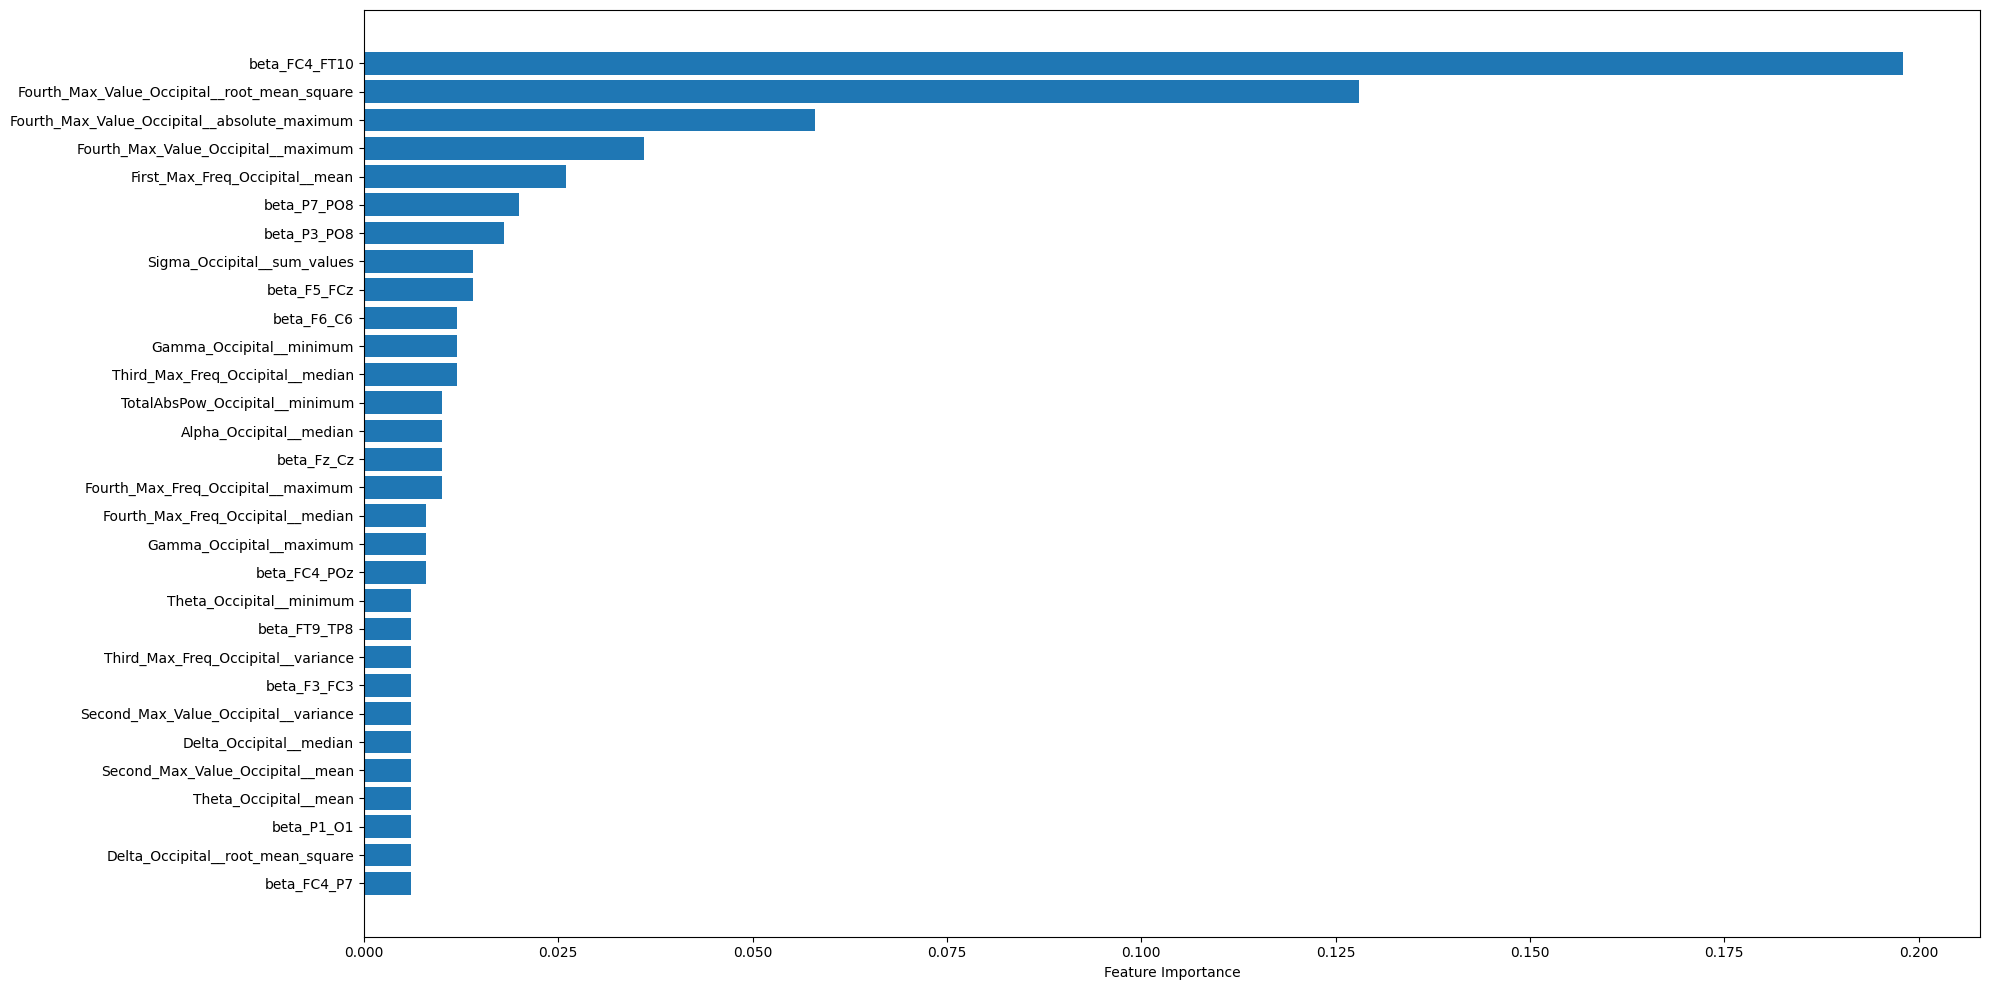

In [63]:
sorted_idx = mean_importances.argsort()

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plt.rcParams["figure.figsize"] = (20,10)
plt.barh(X[regional_features_dict[region]].columns[sorted_idx][-30:] , mean_importances[sorted_idx][-30:])
plt.xlabel("Feature Importance")
plt.tight_layout()

In [ ]:
fig = plt.figure()
fig = plt.figure(figsize=(12,6),dpi=250)